In [168]:
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import folium
from folium import plugins
import geopandas as gpd
from shapely import wkt
from folium.plugins import FastMarkerCluster

In [169]:
data = pd.read_csv("./Downloads/AB_NYC_2019.csv")


In [170]:
data.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [172]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [173]:
# last review and review per month has same number of null values, so they migt be correlated
(data['last_review'].isnull()==data['reviews_per_month'].isnull()).all() 


True

In [174]:
data.loc[data['reviews_per_month'].isnull(),'reviews_per_month']=0 # replacing the missing reviews as zero

In [175]:
data['last_review'] = pd.to_datetime(data['last_review']) #change the data-type for last review to date

In [176]:
(data['last_review'].describe())

count                   38843
unique                   1764
top       2019-06-23 00:00:00
freq                     1413
first     2011-03-28 00:00:00
last      2019-07-08 00:00:00
Name: last_review, dtype: object

In [177]:
data.describe() 

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       48895.000000   
mean         7.029962          23.274466           1.090910   
std         20.510550          44.550582           1.597283   
min          1.000000           0.000000           0.000000   
25%          1.000000           1.000000           0.040000   
50%          3.000000           5.000000           0.370000   
75%          5.000000          24.000000           1.580000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [178]:
data.neighbourhood_group.value_counts(normalize=False) #Manhattan has the maximum number of houses

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [180]:
data.groupby('neighbourhood_group')['price'].describe()
# mean price is highest in Manhattan,followed by Brooklyn and Staten Island

count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                 1091.0   87.496792  106.709349   0.0  45.0   65.0   
Brooklyn             20104.0  124.383207  186.873538   0.0  60.0   90.0   
Manhattan            21661.0  196.875814  291.383183   0.0  95.0  150.0   
Queens                5666.0   99.517649  167.102155  10.0  50.0   75.0   
Staten Island          373.0  114.812332  277.620403  13.0  50.0   75.0   

                       75%      max  
neighbourhood_group                  
Bronx                 99.0   2500.0  
Brooklyn             150.0  10000.0  
Manhattan            220.0  10000.0  
Queens               110.0  10000.0  
Staten Island        110.0   5000.0

In [179]:
data[data.neighbourhood_group=='Manhattan'].groupby('neighbourhood_group')['latitude','longitude'].mean()

latitude  longitude
neighbourhood_group                      
Manhattan            40.765062 -73.974607

In [209]:
#create a new variable distance=distance from Manhattan
from math import sin, cos, sqrt, atan2, radians
lat_manh=data[data.neighbourhood_group=='Manhattan'].groupby('neighbourhood_group')['latitude'].mean()
lat1=radians(lat_manh)#lat1=radians(40.7831)
lon_manh=data[data.neighbourhood_group=='Manhattan'].groupby('neighbourhood_group')['longitude'].mean()
lon1=radians(abs(lon_manh)) #lon1=radians(73.9712)


In [213]:
def radians_lat(lat):
    return radians(lat)
def a(row):
    return sin(row['dlat'] / 2)**2 + cos(lat1) * cos(lat2) * sin(row['dlon'] / 2)**2
def c(row):
    val=2* atan2(sqrt(row), sqrt(1 - row))
    return val
def dist(row):
    distance = R * row
    return distance

In [214]:
data['lat2']=data['latitude'].apply(radians_lat)
data.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  ...  reviews_per_month  \
0     Private room    149  ...               0.21   
1  Entire home/apt    225  ...               0.38   
2     Private room    150  ...               0.00   
3  Entire home/apt     89  ...               4.64   
4  Entire home/apt     80  ...               0.10   

   calculated_host_listings_count availability_365      lat2      lon2  \
0                               6              365  0.709433 -1.291061   
1                               2              355  0.711285 -1.291260   
2                               1              365  0.712252 -1.290530   
3                               1              194  0.710090 -1.290841   
4                               1                0  0.712068 -1.290566   

       dlon      dlat     Value   Value_c     distance  
0 -2.582102 -0.002367  0.426713  1.423693  9073.192307  
1 -2.582301 -0.000515  0.426736  1.423739  9073.489339  
2 -2.581571  0.000452  0.426647  1.423558  9072.334560  
3 -2.581882 -0.001710  0.426685  1.423637  9072.835984  
4 -2.581607  0.000269  0.426651  1.423567  9072.391799  

[5 rows x 23 columns]

In [184]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

#lat1 = radians(40.765062)
#lon1 = radians(21.0122287)

data['lat2']=data['latitude'].apply(radians_lat)
data['lon2'] =data['longitude'].apply(radians_lat)

data['dlon'] = data['lon2'] - lon1
data['dlat'] = data['lat2'] - lat1

#a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
data['Value'] = data.apply(a, axis=1)
data['Value_c'] = data['Value'].apply(c)

data['distance'] = data['Value_c'].apply(dist)

#print("Result:", distance)
#print("Should be:", 278.546, "km")
data.head(5)
#lon1

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  ...  reviews_per_month  \
0     Private room    149  ...               0.21   
1  Entire home/apt    225  ...               0.38   
2     Private room    150  ...               0.00   
3  Entire home/apt     89  ...               4.64   
4  Entire home/apt     80  ...               0.10   

   calculated_host_listings_count availability_365      lat2      lon2  \
0                               6              365  0.709433 -1.291061   
1                               2              355  0.711285 -1.291260   
2                               1              365  0.712252 -1.290530   
3                               1              194  0.710090 -1.290841   
4                               1                0  0.712068 -1.290566   

       dlon      dlat     Value   Value_c     distance  
0 -2.582102 -0.002367  0.426713  1.423693  9073.192307  
1 -2.582301 -0.000515  0.426736  1.423739  9073.489339  
2 -2.581571  0.000452  0.426647  1.423558  9072.334560  
3 -2.581882 -0.001710  0.426685  1.423637  9072.835984  
4 -2.581607  0.000269  0.426651  1.423567  9072.391799  

[5 rows x 23 columns]

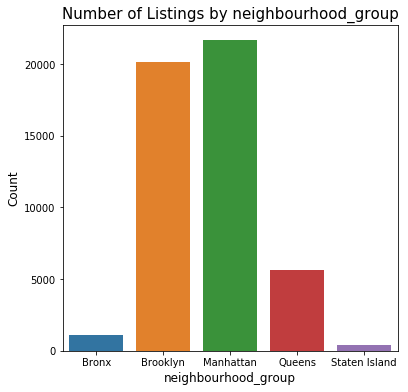

In [102]:
borough_count = data.groupby('neighbourhood_group').agg('count').reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sb.barplot(x='neighbourhood_group', y='id', data=borough_count, ax=ax1)

ax1.set_title('Number of Listings by neighbourhood_group', fontsize=15)
ax1.set_xlabel('neighbourhood_group', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

In [30]:
ny_map = folium.Map(location=[40.7, -74],zoom_start =10)
data_loc= data[['latitude','longitude']].values
data_loc =data_loc.tolist()
hm = plugins.HeatMap(data_loc)
hm.add_to(ny_map)
ny_map

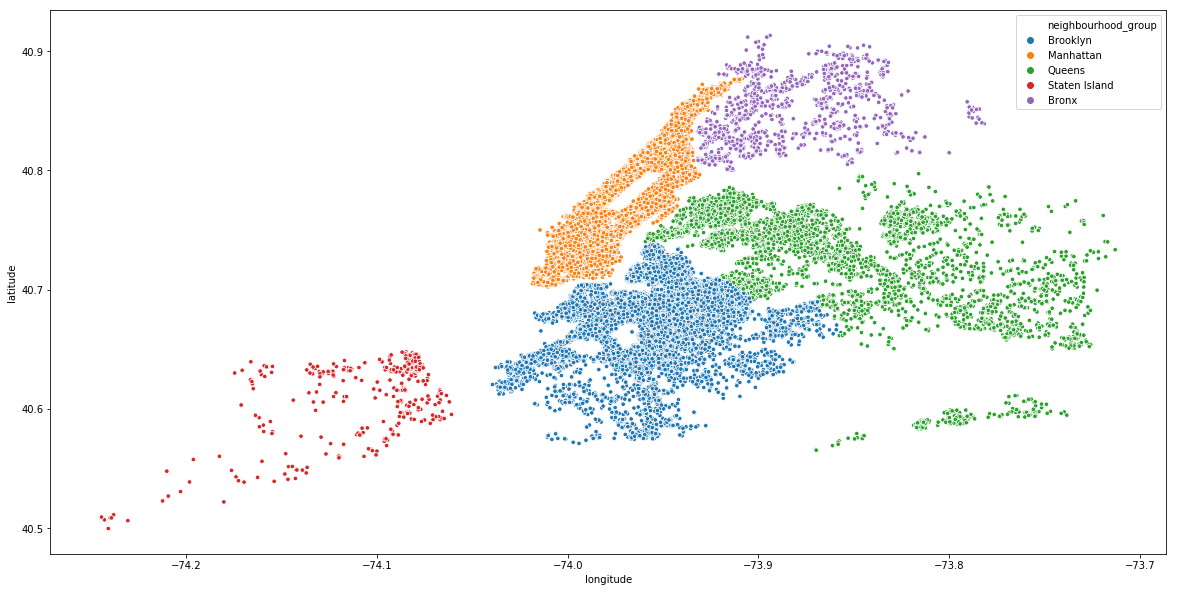

In [31]:
plt.figure(figsize=(20,10))
sb.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',s=20, data=data)

In [103]:
lats2018 = data['latitude'].tolist()
lons2018 = data['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[40.7, -74], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

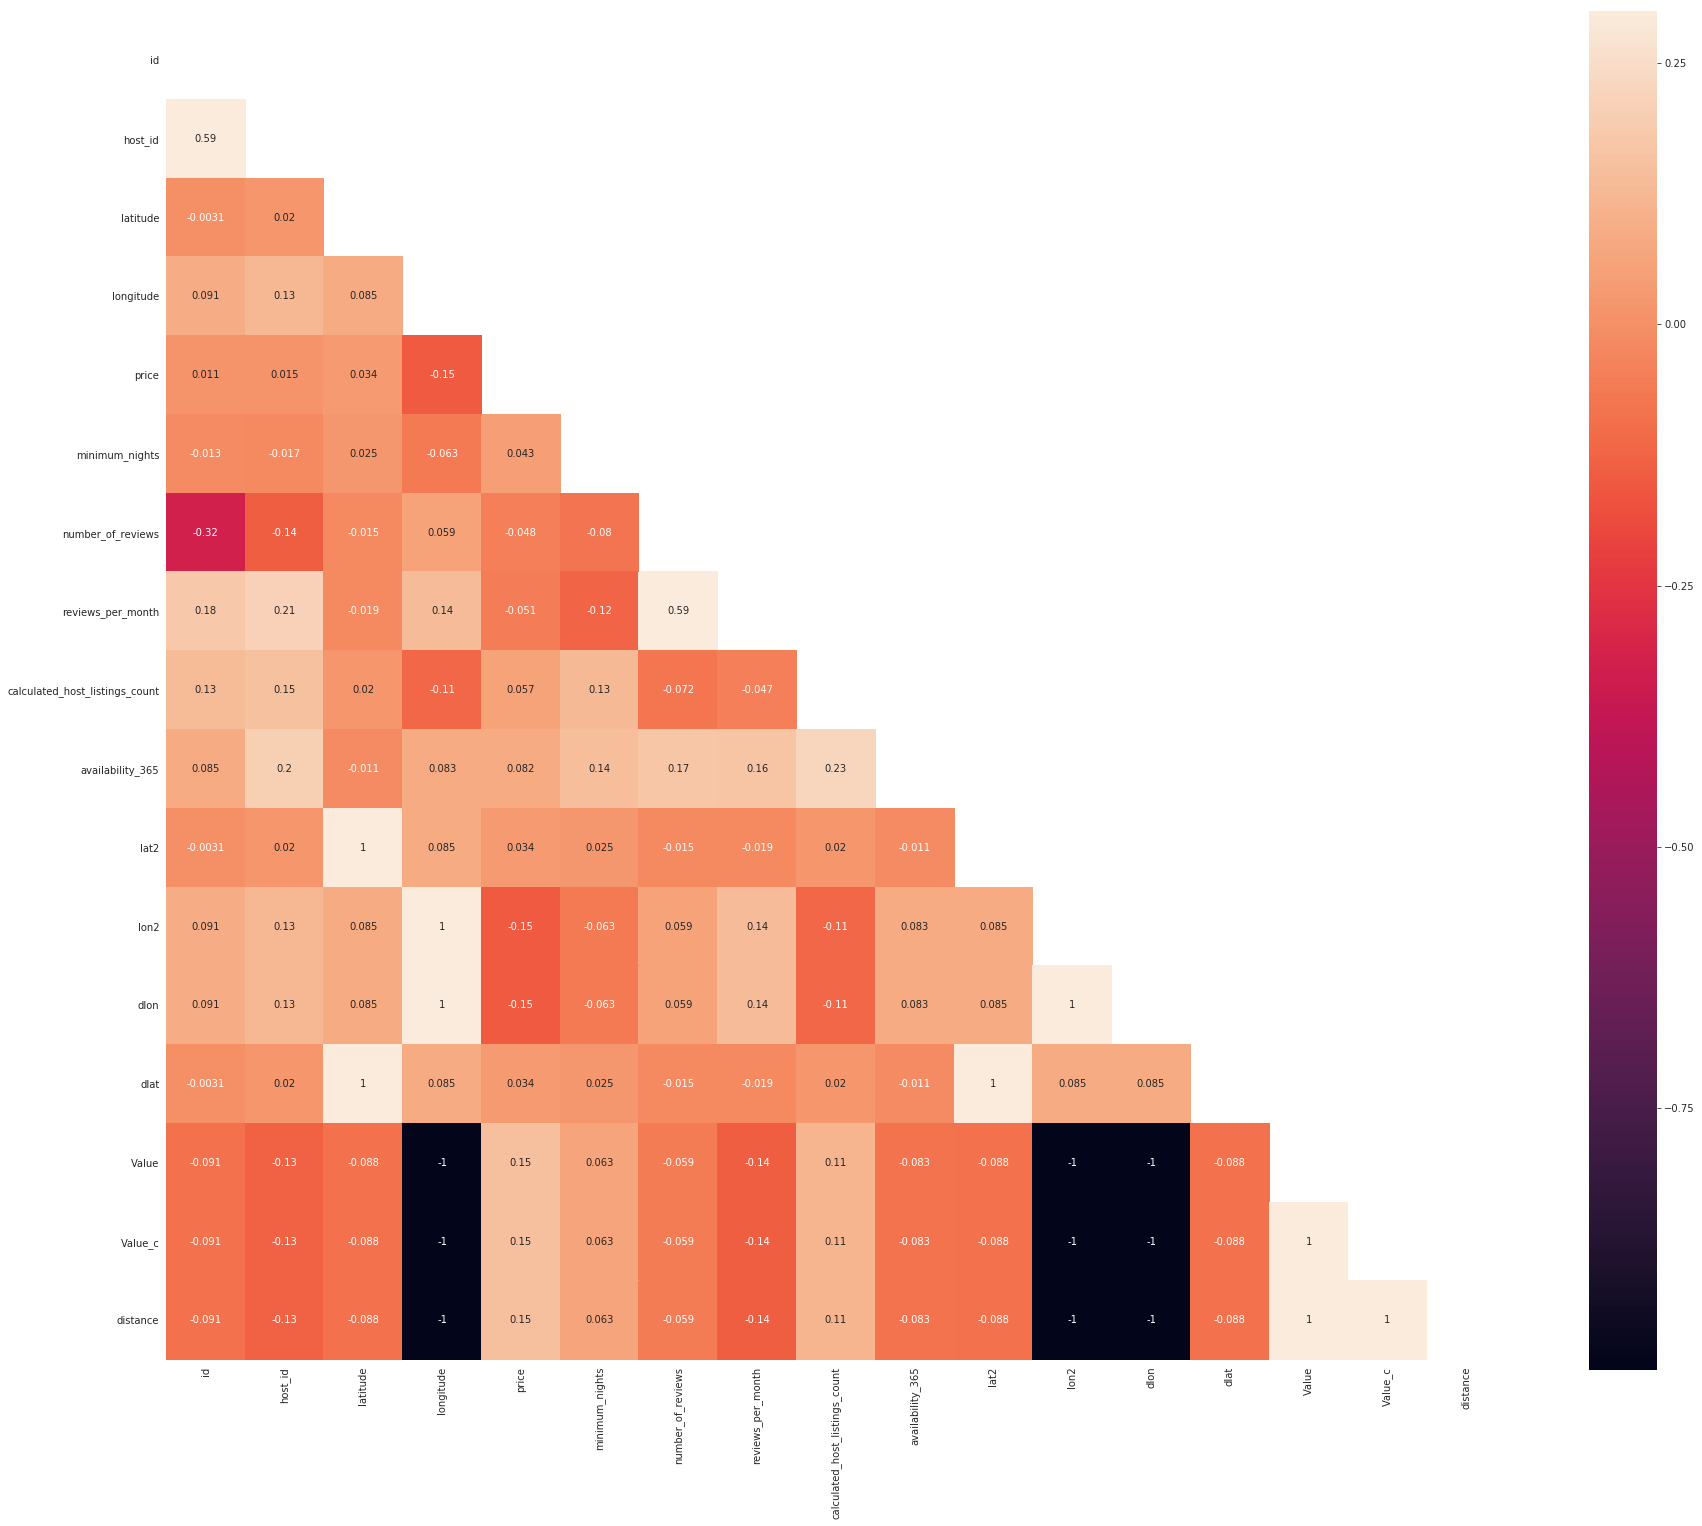

In [186]:
plt.figure(figsize=(30,25))
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    ax = sb.heatmap(corr, mask=mask, annot=True,vmax=.3, square=True)

In [185]:
data.pivot_table(index='neighbourhood_group',columns='room_type',values='price',aggfunc='mean')

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                     127.506596     66.788344    59.800000
Brooklyn                  178.327545     76.500099    50.527845
Manhattan                 249.239109    116.776622    88.977083
Queens                    147.050573     71.762456    69.020202
Staten Island             173.846591     62.292553    57.444444

In [36]:
import plotly.express as px
fig = px.scatter(data, x='availability_365', y="price")
fig.show()
# there are many apartments ehich have zero availability and the price range for them vary largely.

In [188]:
data_new=data[(data.availability_365!=0)&(data.number_of_reviews!=0)] 
# there are some apartments have reviews even thought the availability is zero. They were not eliminated from the data.
data_new.describe()

id       host_id      latitude     longitude         price  \
count  2.615500e+04  2.615500e+04  26155.000000  26155.000000  26155.000000   
mean   1.932026e+07  7.457478e+07     40.727482    -73.947724    149.885184   
std    1.121094e+07  8.261701e+07      0.056936      0.051476    198.816962   
min    2.539000e+03  2.571000e+03     40.506410    -74.244420      0.000000   
25%    9.457278e+06  7.365834e+06     40.687030    -73.982410     70.000000   
50%    2.078323e+07  3.528109e+07     40.721670    -73.953040    109.000000   
75%    2.950917e+07  1.316471e+08     40.763030    -73.929220    175.000000   
max    3.645581e+07  2.738417e+08     40.913060    -73.712990   9999.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    26155.000000       26155.000000       26155.000000   
mean         6.585739          38.193615           1.810126   
std         19.602095          54.359918           1.805707   
min          1.000000           1.000000           0.010000   
25%          1.000000           5.000000           0.450000   
50%          2.000000          16.000000           1.230000   
75%          4.000000          49.000000           2.680000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365          lat2  \
count                    26155.000000      26155.000000  26155.000000   
mean                         6.989715        170.613496      0.710829   
std                         31.807739        124.153024      0.000994   
min                          1.000000          1.000000      0.706970   
25%                          1.000000         53.000000      0.710123   
50%                          1.000000        160.000000      0.710727   
75%                          3.000000        292.000000      0.711449   
max                        327.000000        365.000000      0.714068   

               lon2          dlon          dlat         Value       Value_c  \
count  26155.000000  26155.000000  26155.000000  26155.000000  26155.000000   
mean      -1.290631     -2.581672     -0.000971      0.426659      1.423584   
std        0.000898      0.000898      0.000994      0.000110      0.000223   
min       -1.295810     -2.586851     -0.004829      0.426155      1.422564   
25%       -1.291237     -2.582278     -0.001677      0.426620      1.423504   
50%       -1.290724     -2.581765     -0.001072      0.426671      1.423607   
75%       -1.290308     -2.581349     -0.000350      0.426733      1.423734   
max       -1.286534     -2.577575      0.002268      0.427297      1.424873   

           distance  
count  26155.000000  
mean    9072.499769  
std        1.421387  
min     9065.999671  
25%     9071.992891  
50%     9072.647065  
75%     9073.455060  
max     9080.718503

In [189]:
data_new.shape

(26155, 23)

In [120]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce
le = LabelEncoder()
data['neighbourhood_group'] = le.fit_transform(data['neighbourhood_group'])
ce_one_hot = ce.OneHotEncoder(cols = ['neighbourhood_group'])
ce_one_hot.fit_transform(data['neighbourhood_group'])


neighbourhood_group_1  neighbourhood_group_2  neighbourhood_group_3  \
0                          1                      0                      0   
1                          0                      1                      0   
2                          0                      1                      0   
3                          1                      0                      0   
4                          0                      1                      0   
...                      ...                    ...                    ...   
48890                      1                      0                      0   
48891                      1                      0                      0   
48892                      0                      1                      0   
48893                      0                      1                      0   
48894                      0                      1                      0   

       neighbourhood_group_4  neighbourhood_group_5  
0                          0                      0  
1                          0                      0  
2                          0                      0  
3                          0                      0  
4                          0                      0  
...                      ...                    ...  
48890                      0                      0  
48891                      0                      0  
48892                      0                      0  
48893                      0                      0  
48894                      0                      0  

[48895 rows x 5 columns]

In [126]:
ce_one_hot.get_feature_names()

['neighbourhood_group_1',
 'neighbourhood_group_2',
 'neighbourhood_group_3',
 'neighbourhood_group_4',
 'neighbourhood_group_5']

In [118]:
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name  neighbourhood_group neighbourhood  latitude  longitude  \
0         John                    1    Kensington  40.64749  -73.97237   
1     Jennifer                    2       Midtown  40.75362  -73.98377   
2    Elisabeth                    2        Harlem  40.80902  -73.94190   
3  LisaRoxanne                    1  Clinton Hill  40.68514  -73.95976   
4        Laura                    2   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [190]:
#create dummy for the variable 'neighbourhood_group'
dummy=pd.get_dummies(data_new['neighbourhood_group'])
data_new =pd.concat([data_new,dummy], axis=1)

In [191]:
#create dummy for the variable 'room_type'
dummy=pd.get_dummies(data_new['room_type'])
data_new =pd.concat([data_new,dummy], axis=1)

In [216]:
data_new.pivot_table(index='neighbourhood_group',columns='room_type',values='price',aggfunc='mean')

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                     121.842491     57.228700    58.648649
Brooklyn                  178.816255     77.440654    44.591111
Manhattan                 250.807227    114.672727    75.404494
Queens                    145.173363     66.136637    66.560606
Staten Island             123.296296     58.263514    67.000000

In [215]:
target_column=['availability_365','minimum_nights','number_of_reviews','reviews_per_month','distance',
 'Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'Entire home/apt',
 'Private room',
 'Shared room']
X=data_new[target_column]
y=data_new['price']
X.head()

availability_365  minimum_nights  number_of_reviews  reviews_per_month  \
0               365               1                  9               0.21   
1               355               1                 45               0.38   
3               194               1                270               4.64   
5               129               3                 74               0.59   
7               220               2                430               3.47   

      distance  Bronx  Brooklyn  Manhattan  Queens  Staten Island  \
0  9073.192307      0         1          0       0              0   
1  9073.489339      0         0          1       0              0   
3  9072.835984      0         1          0       0              0   
5  9073.247995      0         0          1       0              0   
7  9073.520779      0         0          1       0              0   

   Entire home/apt  Private room  Shared room  
0                0             1            0  
1                1             0            0  
3                1             0            0  
5                1             0            0  
7                0             1            0

In [194]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [195]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(15693, 13)
(5231, 13)
(5231, 13)


In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from IPython.display import display, Math
from sklearn import metrics
reg = LinearRegression(fit_intercept=False) 
reg = reg.fit(X_train, y_train)
training_error = mean_squared_error(y_train, reg.predict(X_train))
y_pred = reg.predict(X_train)
display(Math(r'$\mathbf{w}_{\rm opt} ='))
optimal_weight = reg.coef_
optimal_weight = optimal_weight.reshape(-1,1)
print(optimal_weight)

print("\nThe resuling training error is ",training_error)
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred)) 

<IPython.core.display.Math object>

[[ 1.45837831e-01]
 [-3.00360245e-01]
 [-2.13807579e-01]
 [-4.20001653e-01]
 [ 1.65231519e+01]
 [-5.61822947e+04]
 [-5.61770144e+04]
 [-5.61290369e+04]
 [-5.61593769e+04]
 [-5.62919708e+04]
 [-9.35615168e+04]
 [-9.36692704e+04]
 [-9.37089064e+04]]

The resuling training error is  40109.257713659186
Mean Squared Error: 40109.257713659186


In [197]:
y_pred = reg.predict(X_train)

#reg.predict(X_val)
r2=metrics.r2_score(y_train,y_pred)
r2

0.11919863145714338

In [198]:
y_pred=reg.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

Actual   Predicted
32337      65   66.514861
18969     150  121.504478
26329      99   61.742074
12113     110  209.358455
38338      59  115.138758
...       ...         ...
36153     325  245.299008
20408     300  167.553637
2479      350  231.348260
25451      45   68.476497
23518     115  137.414956

[5231 rows x 2 columns]

In [199]:
y_pred = reg.predict(X_test)

#reg.predict(X_val)
r2=metrics.r2_score(y_test,y_pred)
r2

0.17252444827359448

In [200]:
y_pred = reg.predict(X_val)

#reg.predict(X_val)
r2=metrics.r2_score(y_val,y_pred)
r2

0.1937352533700234

In [116]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 108.03964572008076
Mean Squared Error: 38489.95157111525
Root Mean Squared Error: 196.18856126470587
